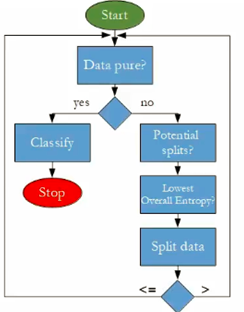 

In [1]:
import pandas as pd
import numpy as np
import math
import random 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

In [2]:
df = pd.read_csv('IRIS.csv')
df = df.rename(columns={"species": "label"})

In [3]:
test_size = 50

In [4]:
indices = df.index.tolist()  #transforme the indexes to list

test_indices = random.sample(population=indices, k=test_size)  #randomly select 20 row for test samples

In [5]:
test_df = df.loc[test_indices]
train_df = df.drop(test_indices)

In [6]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size*len(df))    #if the test size was proportion of the tottal size we calculate it like this
    
    indices = df.index.tolist()  
    test_indices = random.sample(population=indices, k=test_size)
    
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [7]:
random.seed(0)   #each time we call the random function for train dataset it keeps random rows the same 
train_df,test_df = train_test_split(df, test_size=0.4)

In [8]:
len(df)

150

In [9]:
len(test_df)

60

In [10]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [11]:
data = train_df.values

### data pure?
### it will check if the partition of the data contains just one class(pure) or several classes (not pure)

In [12]:
def check_purity(data):
    
    label_column = data[:, -1]   #return the last column of the dataset which is label
    unique_classes = np.unique(label_column)  #how many classes do we have in label
    
    if len(unique_classes)==1:   #if the len is 1 then it has only onw class and it is pure
        return True
    else:
        return False

In [13]:
check_purity(train_df[train_df.index < 50].values)  #it returns true cuz all the first 50 rows have the same lable

True

### classify

In [14]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, count_unique_classes = np.unique(label_column, return_counts=True) #it will return the labels and how often they appeared
    
    index = count_unique_classes.argmax()   #it will return the index of label that appears maximum
    classification = unique_classes[index]
    
    return classification

In [15]:
classify_data(train_df[train_df.index < 25].values)

'Iris-setosa'

In [16]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns-1):   # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:,column_index]
        unique_values = np.unique(values)
        
        for index in range(len(unique_values)):
            if index != 0:   #to skip the first item
                current_value = unique_values[index]
                previous_value = unique_values[index-1]
                potential_split = (previous_value + current_value)/2
                
                potential_splits[column_index].append(potential_split)
                
    return potential_splits

In [17]:
potential_splits = get_potential_splits(train_df.values)

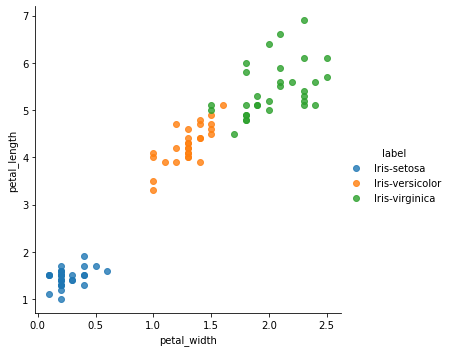

In [18]:
sns.lmplot(data=train_df, x='petal_width', y='petal_length',hue='label', fit_reg = False)

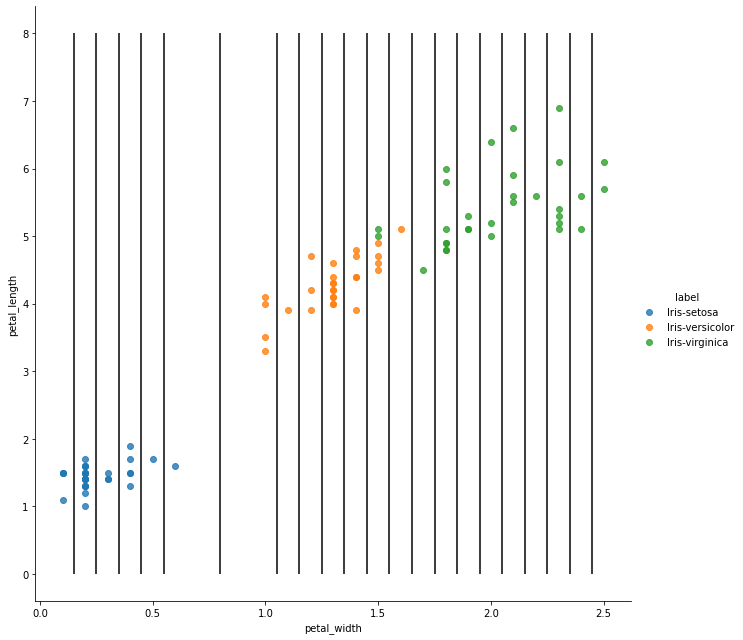

In [19]:
sns.lmplot(data=train_df, x='petal_width', y='petal_length',hue='label', fit_reg = False, height=9)
plt.vlines(x=potential_splits[3], ymin=0, ymax=8)  #vertical lines

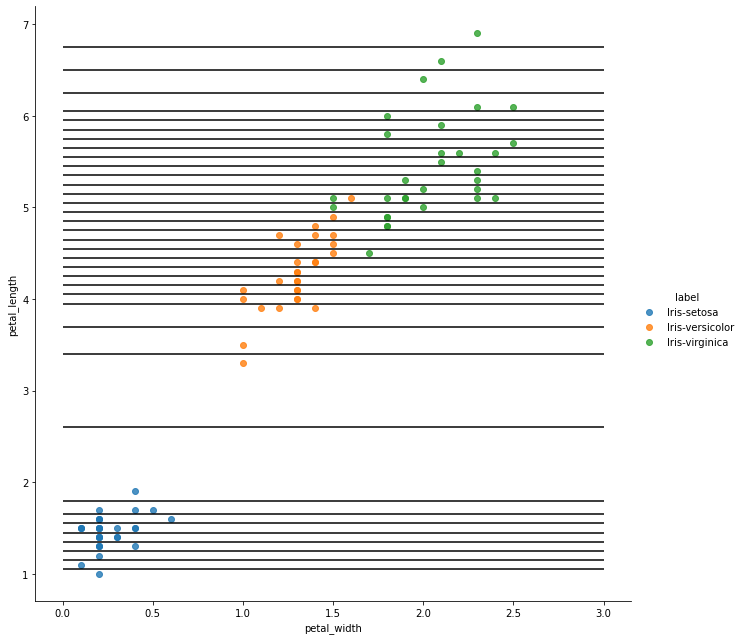

In [20]:
sns.lmplot(data=train_df, x='petal_width', y='petal_length',hue='label', fit_reg = False, height=9)
plt.hlines(y= potential_splits[2], xmin= 0, xmax= 3)  #horizontal lines

### split data

In [21]:
def split_data(data, split_column, split_value):  #the second parameter shows which axis we want to have the line and third the value of the line
    
    split_column_values = data[:,split_column]

    data_below = data[split_column_values <= split_value] #data with the values of feat1 which are less than split_value(1)
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above   #returns the data above the line and below the line

In [22]:
split_column = 3  #petal_width column
split_value = 0.8  #the value of petal_width where the data splits
data_below, data_above = split_data(data, split_column, split_value)

In [42]:
#plotting_data = df.DataFramE(data_below, columns = df.columns)
#sns.lmplot(data=plotting_data, x='feat1', y='feat3', fit_reg = False, height=9)
#plt.vline(x=split_value, ymin= -6, ymax= 18)
#plt.xlim(-5,15)  #to fix the whole x line

### lowest overall entropy

In [24]:
def calculate_entropy(data):
    
    label_column = data[:, -1] #get the last column which is label column

    _, counts = np.unique(label_column, return_counts=True) #store the numbers of total labels

    probabilities = counts/ counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    
    return entropy

In [34]:
calculate_entropy(data_below)

0.0

In [26]:
def calculate_overall_entropy(data_below, data_above):
    
    n_data_point = len(data_below)+len(data_above)
    
    p_data_below = len(data_below)/ n_data_point
    p_data_above = len(data_above)/ n_data_point
    
    overall_entropy = (p_data_below * calculate_entropy(data_below)+
                       p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [27]:
calculate_overall_entropy(data_below, data_above)

0.6543324052526954

In [28]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999     ###?!! why 999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index , split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:   ### why did it use = for fixing with the x axis?
                overall_entropy = current_overall_entropy 
                best_column_split = column_index
                best_value_split = value
                
    return best_column_split,best_value_split

In [29]:
determine_best_split(data, potential_splits)

(3, 0.8)

In [30]:
def decision_tree_algorithm(df, counter=0, min_samples=2):
    
    
    if counter == 0:   #we are in the first call
        global column_name
        column_name = df.columns
        data = df.values   # data is a dataframe    vid5?!! https://www.youtube.com/watch?v=0PUxeGFNO2I
        
    else :
        data = df    #data is a numpy array
        
    #base cases
    if (check_purity(data)) or (len(data)<min_samples):
        classification = classify_data(data)
        return classification
    
    #recursive part
    else:
        counter += 1

        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        #instantate sub_tree
        feature_name = column_name[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question:[]}

        #find answers
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples)
        

        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)

        return sub_tree

In [35]:
tree = decision_tree_algorithm(train_df)
pprint(tree)

{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_width <= 1.65': [{'petal_length <= 4.95': ['Iris-versicolor',
                                                                           {'petal_width <= 1.55': ['Iris-virginica',
                                                                                                    'Iris-versicolor']}]},
                                                 'Iris-virginica']}]}
